In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset
df = pd.read_csv('/home/zayan/ML/Project23/AB_NYC_2019.csv')

# Cleaning the data
df['last_review'] = pd.to_datetime(df['last_review'])
df['last_review'] = df['last_review'].ffill()
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df[['name', 'host_name']] = df[['name','host_name']].fillna('Unknown')

# Removing outliers based on price and minimum_nights
df[['price','minimum_nights']].describe() 
df = df[~((df['price'] > 1000) | (df['minimum_nights'] > 365))]

# Checking the cleaned data
df.info()
df.isnull().sum() # No missing values
df.dtypes # Correct dtypes

<class 'pandas.core.frame.DataFrame'>
Index: 48642 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              48642 non-null  int64         
 1   name                            48642 non-null  object        
 2   host_id                         48642 non-null  int64         
 3   host_name                       48642 non-null  object        
 4   neighbourhood_group             48642 non-null  object        
 5   neighbourhood                   48642 non-null  object        
 6   latitude                        48642 non-null  float64       
 7   longitude                       48642 non-null  float64       
 8   room_type                       48642 non-null  object        
 9   price                           48642 non-null  int64         
 10  minimum_nights                  48642 non-null  int64         
 11  number_

id                                         int64
name                                      object
host_id                                    int64
host_name                                 object
neighbourhood_group                       object
neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                                 object
price                                      int64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
dtype: object

# Add Markdown


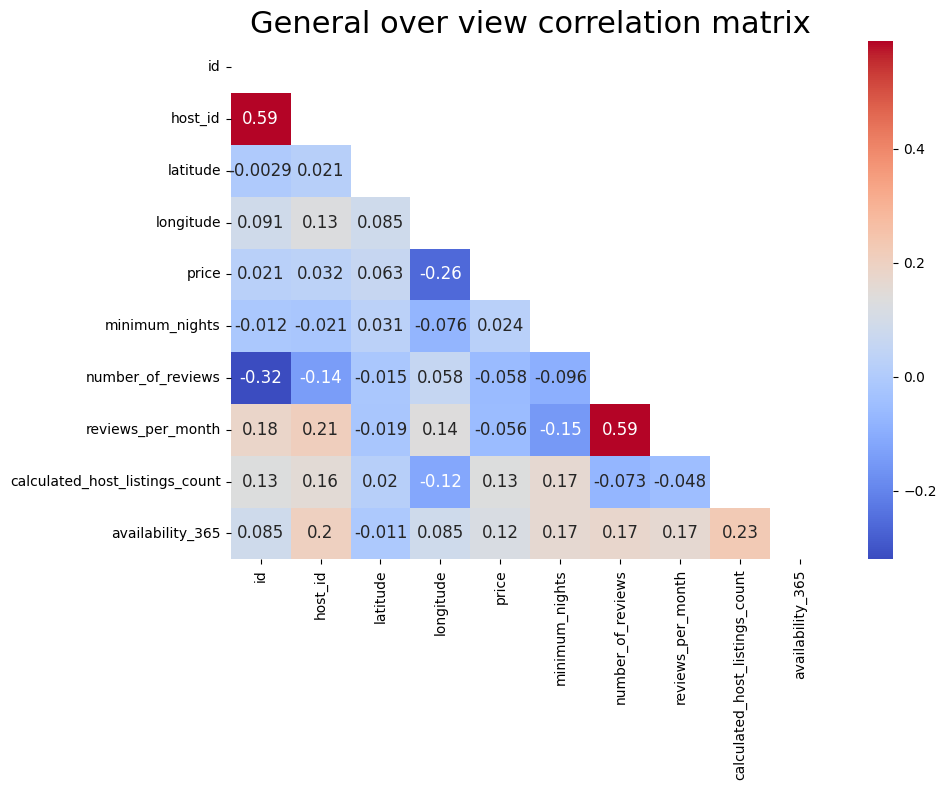

In [4]:
# Select only numeric columns for correlation analysis
df_for_corr = df.select_dtypes(include=['number'])
corr_matrix = df_for_corr.corr()

masktriu = np.triu(np.ones(corr_matrix.shape))

# Plot the correlation matrix

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cbar=True, cmap='coolwarm',fmt='.2g', 
            mask=masktriu, annot_kws={'size':12})
plt.title('General over view correlation matrix', size=22)

plt.tight_layout()
plt.show()

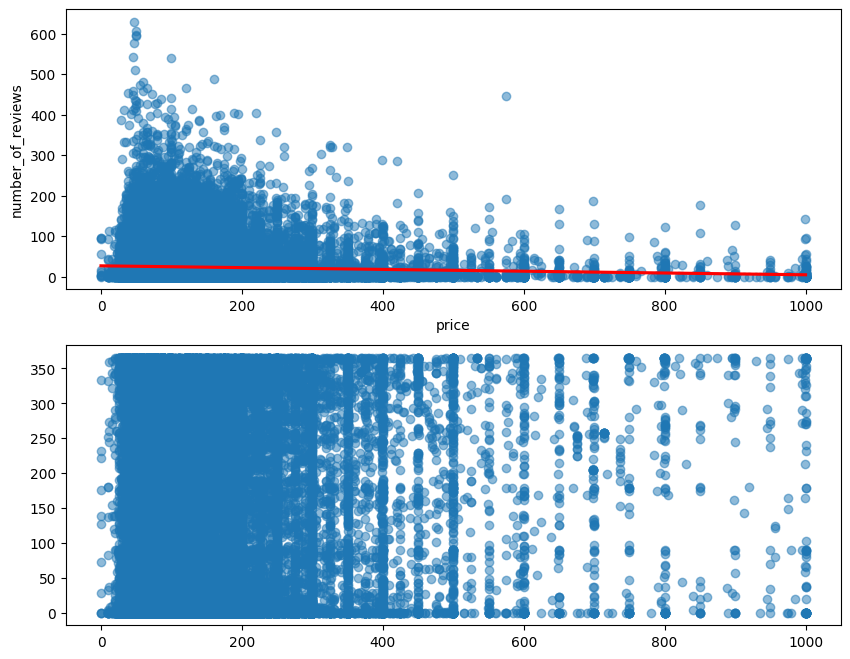

In [5]:
fig,axes = plt.subplots(2,1,figsize=(10,8))

sns.regplot(x=df['price'], y=df['number_of_reviews'], scatter_kws={'alpha':0.5}, line_kws={'color':'red'}, ax=axes[0])
# axes[0].xlabel('Price (log scale)')
# axes[0].ylabel('Number of Reviews (log scale)')
axes[1].scatter(df['price'], df['availability_365'], alpha=0.5)
# plt.title('Title')

plt.show()

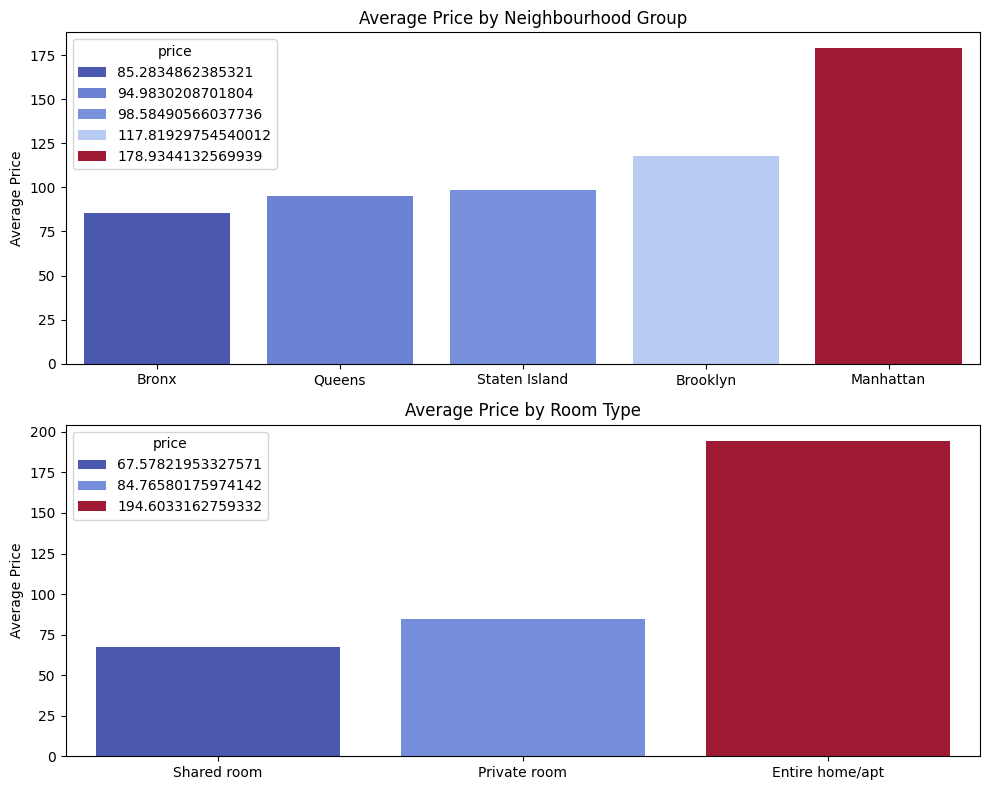

In [6]:
# Analyzing price based on neighborhood and room type
price_per_neighbour = df.groupby('neighbourhood_group')['price'].mean().sort_values()
price_per_room = df.groupby('room_type')['price'].mean().sort_values()

# Resetting index for better formatting
price_per_neighbour = price_per_neighbour.reset_index().set_index('neighbourhood_group')
price_per_room = price_per_room.reset_index().set_index('room_type')

# Visualizing average price by neighborhood and room type
fig, axes = plt.subplots(2,1,figsize=(10,8))

sns.barplot(x=price_per_neighbour.index,y='price', data=price_per_neighbour, 
            hue='price',palette='coolwarm',ax=axes[0])
axes[0].set_title('Average Price by Neighbourhood Group')
axes[0].set_ylabel('Average Price')
axes[0].set_xlabel('')

sns.barplot(x=price_per_room.index,y='price', data=price_per_room, 
            hue='price', palette='coolwarm',ax=axes[1])
axes[1].set_title('Average Price by Room Type')
axes[1].set_ylabel('Average Price')
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()

/tmp/ipykernel_1020/2710875773.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  availability_trend = df.groupby('availability_bin')['number_of_reviews'].mean()


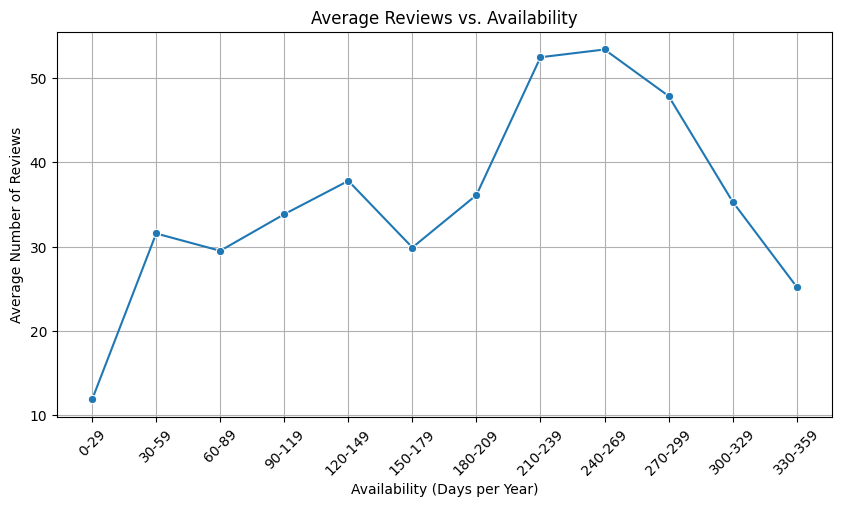

In [7]:
# Analyzing relationship between availability and reviews
# Creating bins for availability
bins = list(range(0, 366, 30))  
labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]

# Create a new column 'availability_bin' for availability bins
df['availability_bin'] = pd.cut(df['availability_365'], bins=bins, labels=labels, right=False)

# Aggregating average number of reviews per availability bin
availability_trend = df.groupby('availability_bin')['number_of_reviews'].mean()

# Plotting the trend
plt.figure(figsize=(10,5))
sns.lineplot(x=availability_trend.index, y=availability_trend.values, marker='o')

plt.title('Average Reviews vs. Availability')
plt.xlabel('Availability (Days per Year)')
plt.ylabel('Average Number of Reviews')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

### Making ready for ML 

In [8]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Select categorical columns to encode
categorical_cols = ['neighbourhood_group', 'room_type']

# Fit and transform
encoded_array = encoder.fit_transform(df[categorical_cols])

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate the encoded columns back to the original DataFrame
df = df.drop(columns=categorical_cols).reset_index(drop=True)
df = pd.concat([df, encoded_df], axis=1)

# Check result
df.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,...,reviews_per_month,calculated_host_listings_count,availability_365,availability_bin,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Private room,room_type_Shared room
0,2539,Clean & quiet apt home by the park,2787,John,Kensington,40.64749,-73.97237,149,1,9,...,0.21,6,365,NaN,1.0,0.0,0.0,0.0,1.0,0.0
1,2595,Skylit Midtown Castle,2845,Jennifer,Midtown,40.75362,-73.98377,225,1,45,...,0.38,2,355,330-359,0.0,1.0,0.0,0.0,0.0,0.0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Harlem,40.80902,-73.94190,150,3,0,...,0.00,1,365,NaN,0.0,1.0,0.0,0.0,1.0,0.0
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Clinton Hill,40.68514,-73.95976,89,1,270,...,4.64,1,194,180-209,1.0,0.0,0.0,0.0,0.0,0.0
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,East Harlem,40.79851,-73.94399,80,10,9,...,0.10,1,0,0-29,0.0,1.0,0.0,0.0,0.0,0.0


In [9]:
# Creating new features
df['price_per_night'] = df['price'] / df['minimum_nights']
df['review_intensity'] = df['reviews_per_month'] / df['availability_365']

# Handling potential infinite or NaN values
df.loc[df['price_per_night'].isin([np.inf, -np.inf]), 'price_per_night'] = np.nan
df['price_per_night'] = df['price_per_night'].fillna(df['price_per_night'].median())

df.loc[df['review_intensity'].isin([np.inf, -np.inf]), 'review_intensity'] = np.nan
df['review_intensity'] = df['review_intensity'].fillna(0)  # If availability is 0, set intensity to 0

# Checking the new features
df[['price_per_night', 'review_intensity']].describe()

,price_per_night,review_intensity
count,48642.000000,48642.000000
mean,64.281688,0.035850
std,78.123207,0.212071
min,0.000000,0.000000
25%,20.000000,0.000000
50%,44.000000,0.000597
75%,80.000000,0.011764
max,1000.000000,10.170000


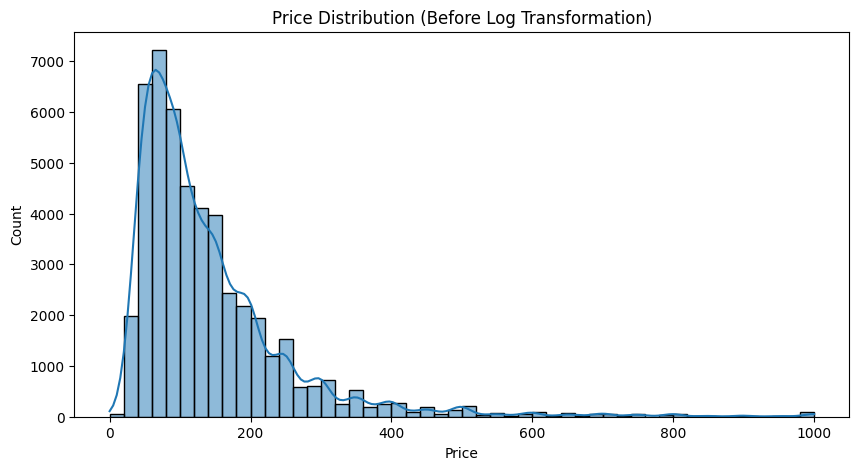

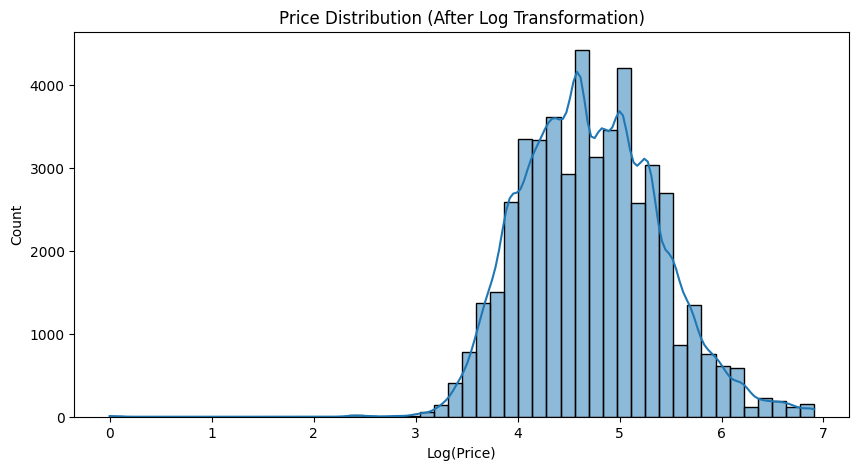

,log_price,availability_365,price_per_night,review_intensity
0,0.432620,1.922463,1.084430,-0.166337
1,1.048434,1.846358,2.057263,-0.164003
2,0.442602,1.922463,-0.182812,-0.169050
3,-0.334821,0.621067,0.316405,-0.056268
4,-0.493110,-0.855371,-0.720430,-0.169050


In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Visualizing price distribution before transformation
plt.figure(figsize=(10,5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Price Distribution (Before Log Transformation)')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

# Log transformation of the 'price' column to reduce skewness
df['log_price'] = np.log1p(df['price'])

# Visualizing price distribution after log transformation
plt.figure(figsize=(10,5))
sns.histplot(df['log_price'], bins=50, kde=True)
plt.title('Price Distribution (After Log Transformation)')
plt.xlabel('Log(Price)')
plt.ylabel('Count')
plt.show()

# Scaling numerical features using StandardScaler
num_features = ['log_price', 'availability_365', 'price_per_night', 'review_intensity']
scaler = StandardScaler()
df[num_features] = scaler.fit_transform(df[num_features])

# Check scaled values
df[num_features].head()

# Small ML Model

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
# Select numeric columns and handle missing values
df_for_ml = df.select_dtypes(include=['number']).dropna()


# Create the data (X) and target (y)
x = df_for_ml.drop('price', axis=1)
y = df_for_ml['price']

# Identify numeric columns
numeric_columns = x.select_dtypes(include=['float64', 'int64']).columns

# Handle missing values for numeric columns (impute with median)
imputer = SimpleImputer(strategy='median')
x[numeric_columns] = imputer.fit_transform(x[numeric_columns])

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Create and fit the model
model = LinearRegression().fit(x_train, y_train)

# Show the model's score (R^2 score for regression models)
score = model.score(x_test, y_test)
print(f"Model R^2 Score: {score}")

# Calculate Mean Squared Error for a better understanding of the performance
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Model R^2 Score: 0.8378858045637185
Mean Squared Error: 2139.4233100132114
